In [227]:
import os
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np
 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.compose import ColumnTransformer
from scipy.stats import norm
import scipy.stats as stats
import numpy as np

---
# Inimse hingamise sageduse ja teiste füüsiliste parameetrite regressioonanalüüs
## ITB8814 Andmekaevandamine, Projekt
### Autor: Juri Lunin
Kuupäev 17.05.2024

<style>
body p {
  text-align: justify
}
</style>

# Sissejuhatus

<p>
Käesolevas projektitöö on valitud uurimiseks andmestik: "Energy Expenditure of Human Physical Activity".
</p>

## Andmestiku kirjeldus

Andmestikus on inimeste füüsilised omadused ja info nende seisundi kohta, mis avaldub füüsilise aktiivsuse ajal.
<a href="https://www.kaggle.com/datasets/anonymousds/energy-expenditure-of-human-physical-activity">Energy Expenditure of Human Physical Activity</a>  Faili formaat: csv*.

Andmestikuga koos on postitatud kaks teadusliku artikli:

<p>

<ul>

<li><a href="https://link.springer.com/article/10.1007/s11257-020-09268-2">Activity recognition using wearable sensors for tracking the elderly</a></li>

<li><a href="https://link.springer.com/article/10.1007/s10618-021-00817-w">A recurrent neural network architecture to model physical activity energy expenditure in older people</a></li>

</ul>

</p>

Andmestiku tunnused:

<ul>
<li>ID - participant's ID</li>
<li>trial_date - date and time when data collection started at ID level</li>
<li>gender - sex = male or female</li>
<li>age	in years</li>
<li>weight	in kg</li>
<li>height	in cm</li>
<li>bmi	Body mass index in kg/m</li>
<li>gaAnkle	TRUE if data from GENEActiv on the ankle exist, FALSE otherwise</li>
<li>gaChest	TRUE if data from GENEActiv on the chest exist, FALSE otherwise</li>
<li>gaWrist	TRUE if data from GENEActiv on the wrist exist, FALSE otherwise</li>
<li>equivital	TRUE if data from Equivital exist, FALSE otherwise</li>
<li>cosmed	TRUE if data from COSMED exist, FALSE otherwise</li>
<li>EEm	Energy Expenditure per minute, in Kcal</li>
<li>COSMEDset_row	the original indexes of COSMED data (used for merging)</li>
<li>EEh	Energy Expenditure per hour, in Kcal</li>
<li>EEtot	Total Kcal spent (it is reseted between indoor and outdoor measurements)</li>
<li>METS	Metabolic Equivalent per minute</li>
<li>Rf	Respiratory Frequency (litre/min)</li>
<li>BR	Breath Rate</li>
<li>VT	Tidal Volume in litre</li>
<li>VE	Expiratory Minute Ventilation (litre/min)</li>
<li>VO2	Oxygen Uptake (ml/min)</li>
<li>VCO2	Carbon Dioxide production (ml/min)</li>
<li>O2exp	Volume of O2 expired (ml/min)</li>
<li>CO2exp	Volume of CO2 expired (ml/min)</li>
<li>FeO2	Averaged expiratory concentration of O2 (%)</li>
<li>FeCO2	Averaged expiratory concentration of CO2 (%)</li>
<li>FiO2	Fraction of inspired O2 (%)</li>
<li>FiCO2	Fraction of inspired CO2 (%)</li>
<li>VE.VO2	Ventilatory equivalent for O2</li>
<li>VE.VCO2	Ventilatory equivalent for CO2</li>
<li>R	Respiratory Quotient</li>
<li>Ti	Duration of Inspiration (seconds)</li>
<li>Te	Duration of Expiration (seconds)</li>
<li>Ttot	Duration of Total breathing cycle (seconds)</li>
<li>VO2.HR	Oxygen pulse (ml/beat)</li>
<li>HR	Heart Rate</li>
<li>Qt	Cardiac output (litre)</li>
<li>SV	Stroke volume (litre/min)</li>
<li>original_activity_labels	True activity label as noted from study protocol, NA if is unknown</li>
<li>predicted_activity_label	Predicted activity label by model from [1], NA if is unknown</li>
</ul>

</p>

## Uurimiseesmärk

Prognoositav tunnus ehk sihttunnus on Y=“BR” breath rate.

Eesmärk: parima mitme argumendiga regressiooni mudeli leidmine sihttunnuse *BR* prognoosimiseks.

## Tööülesanded (tööhüpoteesid)

1. Madalama hingamise sagedusega inimestel on tugevam tervis.

## Metoodika ja uuringu käik

Käesoleva projektis kasutasime järgnevaid analüüsi meetodeid:

<ul>
<li>Lineaarregressioon</li>
<li>Polünomiaalregressioon</li>
<li>Otsustuspuu regressiooni mudel</li>
<li>Random forest regressiooni mudel</li>
</ul>

## Sisukord

* [Andmeteanalüüs](#andm)
* [Andmete lugemune](#luge)
* [Ülevaade andmestiku struktuurist](#str)
* [Andmestiku puhastamine](#puh)
* [Tunnuste teisendamine](#teis)
* [Tunnuste kirjeldus](#kirj)
* [Seoste analüüs](#seos)
* [Lineaarregressioon](#line)
* [Polünomiaalregressioon](#poly)
* [Otsustuspuu regressioon](#otsu)
* [Gandom Forest regressioon](#rand)

In [228]:
_DATA_PATH = 'data/EEHPA.csv'
_SIHTTUNNUS_ = 'BR'
_GOAL_ = 'Leida parima mitme argumendiga regressiooni mudeli sihttunnuse BR ennustamise jaoks.'
_DROP_= ['gaAnkle', 'gaChest', 'gaWrist', 'equivital', 'cosmed']
_OBJ_CAST_= []
_DROP_UNNAMED_ = True

Kustutuame boolean tunnused seadmetest andmete kohta 'gaAnkle', 'gaChest', 'gaWrist', 'equivital', 'cosmed'.

<a id='andm'></a>
# Andmeanalüüs

<a id='luge'></a>
## Andmete lugemine

In [229]:
df = pd.read_csv(_DATA_PATH)
df

,ID,trial_date,gender,age,weight,height,bmi,gaAnkle,gaChest,gaWrist,...,R,Ti,Te,Ttot,VO2.HR,HR,Qt,SV,original_activity_labels,predicted_activity_label
0,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,True,True,True,...,0.98,0.93,1.86,2.79,2.13,102,0,0,NaN,sitting
1,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,True,True,True,...,1.00,1.26,1.18,2.44,2.24,103,0,0,NaN,NaN
2,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,True,True,True,...,1.04,0.97,1.69,2.66,4.21,104,0,0,NaN,NaN
3,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,True,True,True,...,1.06,0.96,2.04,3.00,4.33,106,0,0,lyingDownRight,standing
4,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,True,True,True,...,1.03,1.15,1.57,2.72,2.61,106,0,0,lyingDownRight,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38718,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,True,True,True,...,0.81,1.01,1.74,2.75,3.94,77,0,0,NaN,standing
38719,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,True,True,True,...,0.78,1.11,1.91,3.02,3.18,77,0,0,NaN,NaN
38720,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,True,True,True,...,0.76,0.83,1.41,2.24,7.33,77,0,0,NaN,NaN
38721,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,True,True,True,...,0.79,1.25,2.77,4.02,4.44,77,0,0,NaN,NaN


<a id='str'></a>

## Ülevaade andmestiku struktuurist

Andmestiku suurus:

In [230]:
print(f"Andmestikus on \033[1m{df.shape[0]}\033[0m ridu, neid iseloomustab \033[1m{df.shape[1]}\033[0m tunnust.")

Andmestikus on 38723 ridu, neid iseloomustab 41 tunnust.


Andmestiku muutujad:

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38723 entries, 0 to 38722
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        38723 non-null  object 
 1   trial_date                38723 non-null  object 
 2   gender                    38723 non-null  object 
 3   age                       38723 non-null  float64
 4   weight                    38723 non-null  float64
 5   height                    38723 non-null  int64  
 6   bmi                       38723 non-null  float64
 7   gaAnkle                   38723 non-null  bool   
 8   gaChest                   38723 non-null  bool   
 9   gaWrist                   38723 non-null  bool   
 10  equivital                 38723 non-null  bool   
 11  cosmed                    38723 non-null  bool   
 12  EEm                       38723 non-null  float64
 13  COSMEDset_row             38723 non-null  int64  
 14  EEh   

In [232]:
print_prop_num_count = len(df.select_dtypes(exclude=object).columns)
print_prop_obj_count = len(df.select_dtypes(include=object).columns)

print(f"Andmestikus on \033[1m{print_prop_num_count}\033[0m arvulist ja \033[1m{print_prop_obj_count}\033[0m mittearvulist muutujat")

Andmestikus on 36 arvulist ja 5 mittearvulist muutujat


In [233]:
if len(_OBJ_CAST_) > 0:
    obj_cast_l = {}
    for i in _OBJ_CAST_:
        if i in df:
            obj_cast_l.update({i: str})
    
    df = df.astype(obj_cast_l)
        
    df.info()

In [234]:
if len(_OBJ_CAST_) > 0:
    
    print("Teisendame järgmised tunnused kategoriaalseteks:")
    print(f"\033[1m{[i for i in _OBJ_CAST_]}\033[0m")
    
    print_prop_num_count = len(df.select_dtypes(exclude=object).columns)
    print_prop_obj_count = len(df.select_dtypes(include=object).columns)

    print(f"Andmestikus on \033[1m{print_prop_num_count}\033[0m arvulist ja \033[1m{print_prop_obj_count}\033[0m mittearvulist muutujat")

<a id='puh'></a>
## Andmestiku puhastamine

### Duplikaatide kontroll

In [235]:
duplicates = df.duplicated(keep='first').sum();
print(f"Andmestikus on leitud {duplicates} duplikaate.")

Andmestikus on leitud 28 duplikaate.


In [236]:
df.drop_duplicates(keep='first',inplace=True)
duplicates_new = df.duplicated(keep='first').sum()
print(f"Peale puhastamist andmestikus on leitud {duplicates_new} duplikaate.")

Peale puhastamist andmestikus on leitud 0 duplikaate.


<a id='teisj'></a>
# Tunnuste teisendamine

### Puuduvate andmetega objektide kontroll

In [237]:
missing_values_validation = df.isna().sum()
missing_values_validation

ID                              0
trial_date                      0
gender                          0
age                             0
weight                          0
height                          0
bmi                             0
gaAnkle                         0
gaChest                         0
gaWrist                         0
equivital                       0
cosmed                          0
EEm                             0
COSMEDset_row                   0
EEh                             0
EEtot                           0
METS                            0
Rf                              0
BR                              0
VT                              0
VE                              0
VO2                             0
VCO2                            0
O2exp                           0
CO2exp                          0
FeO2                            0
FeCO2                           0
FiO2                            0
FiCO2                           0
VE.VO2        

Puuduvate väärtustega 'N/A' kirjed puuduvad.

In [238]:
print(f"Puhastatud andmestikus on \033[1m{df.shape[0]}\033[0m ridu, neid iseloomustab \033[1m{df.shape[1]}\033[0m tunnust.")

Puhastatud andmestikus on 38695 ridu, neid iseloomustab 41 tunnust.


<a id='teisj'></a>
# Tunnuste teisendamine

In [239]:
if len(_DROP_) > 0:
    prep_validated_drop_list = []
    for i in _DROP_:
        if i in df:
            prep_validated_drop_list.append(i)
    
    if len(prep_validated_drop_list) > 0:
        df.drop(columns=prep_validated_drop_list,axis = 1, inplace = True)

In [240]:
if _DROP_UNNAMED_:   
    prep_empty_cols = df.columns.str.contains('unnamed',case = False)

    if len(np.where(prep_empty_cols == True)) > 0:
        df.drop(df.columns[prep_empty_cols],axis = 1, inplace = True)
    
df

,ID,trial_date,gender,age,weight,height,bmi,EEm,COSMEDset_row,EEh,...,R,Ti,Te,Ttot,VO2.HR,HR,Qt,SV,original_activity_labels,predicted_activity_label
0,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,1.08,0,65.01,...,0.98,0.93,1.86,2.79,2.13,102,0,0,NaN,sitting
1,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,1.16,1,69.54,...,1.00,1.26,1.18,2.44,2.24,103,0,0,NaN,NaN
2,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,2.22,2,132.97,...,1.04,0.97,1.69,2.66,4.21,104,0,0,NaN,NaN
3,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,2.34,3,140.45,...,1.06,0.96,2.04,3.00,4.33,106,0,0,lyingDownRight,standing
4,GOTOV05,08/02/2016 13:42,female,61.60,68.60,162,26.10,1.40,4,83.88,...,1.03,1.15,1.57,2.72,2.61,106,0,0,lyingDownRight,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38718,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,1.45,963,87.11,...,0.81,1.01,1.74,2.75,3.94,77,0,0,NaN,standing
38719,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,1.16,964,69.69,...,0.78,1.11,1.91,3.02,3.18,77,0,0,NaN,NaN
38720,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,2.67,965,160.01,...,0.76,0.83,1.41,2.24,7.33,77,0,0,NaN,NaN
38721,GOTOV36,30/05/2016 10:41,female,81.30,72.00,167,25.80,1.63,966,97.65,...,0.79,1.25,2.77,4.02,4.44,77,0,0,NaN,NaN


In [241]:
print_prop_num_count = len(df.select_dtypes(exclude=object).columns)
print_prop_obj_count = len(df.select_dtypes(include=object).columns)

print(f"Andmestikus on \033[1m{print_prop_num_count}\033[0m arvulist ja \033[1m{print_prop_obj_count}\033[0m mittearvulist muutujat")

Andmestikus on 31 arvulist ja 5 mittearvulist muutujat


Andmestik sobib mudelitele ilma muutusteta.

<a id='kirj'></a>

# Tunnuste kirjeldus

## Arvuliste tunnuste kirjeldus

Arvuliste tunnuste karakteristikud:

In [242]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,38695.00,65.57,4.79,59.50,61.60,64.60,68.10,81.30
weight,38695.00,82.98,11.21,64.10,74.60,82.70,91.00,117.00
height,38695.00,174.60,7.72,160.00,170.00,176.00,180.00,190.00
bmi,38695.00,27.14,2.47,24.00,25.50,26.80,28.10,35.30
EEm,38695.00,4.03,2.62,0.00,2.04,3.32,5.39,21.58
COSMEDset_row,38695.00,694.42,460.20,0.00,312.00,627.00,1033.00,1856.00
EEh,38695.00,241.84,157.25,0.00,122.41,199.39,323.10,1294.81
EEtot,38695.00,73.08,52.11,0.00,34.37,63.59,100.59,291.44
METS,38695.00,2.85,1.81,0.00,1.47,2.39,3.87,15.23
Rf,38695.00,23.99,10.80,2.89,18.13,22.30,27.78,375.00


Visualiseerime arvuliste muutujate jaotused. Selleks eraldame andmestikust arvulised muutujad:

In [243]:
feature_columns=df.drop(_SIHTTUNNUS_, axis=1).select_dtypes(exclude=object).columns
feature_columns

Index(['age', 'weight', 'height', 'bmi', 'EEm', 'COSMEDset_row', 'EEh',
       'EEtot', 'METS', 'Rf', 'VT', 'VE', 'VO2', 'VCO2', 'O2exp', 'CO2exp',
       'FeO2', 'FeCO2', 'FiO2', 'FiCO2', 'VE.VO2', 'VE.VCO2', 'R', 'Ti', 'Te',
       'Ttot', 'VO2.HR', 'HR', 'Qt', 'SV'],
      dtype='object')

Arvuliste tunnuste jaotuste visualiseerimine: histogramm + karpdiagramm

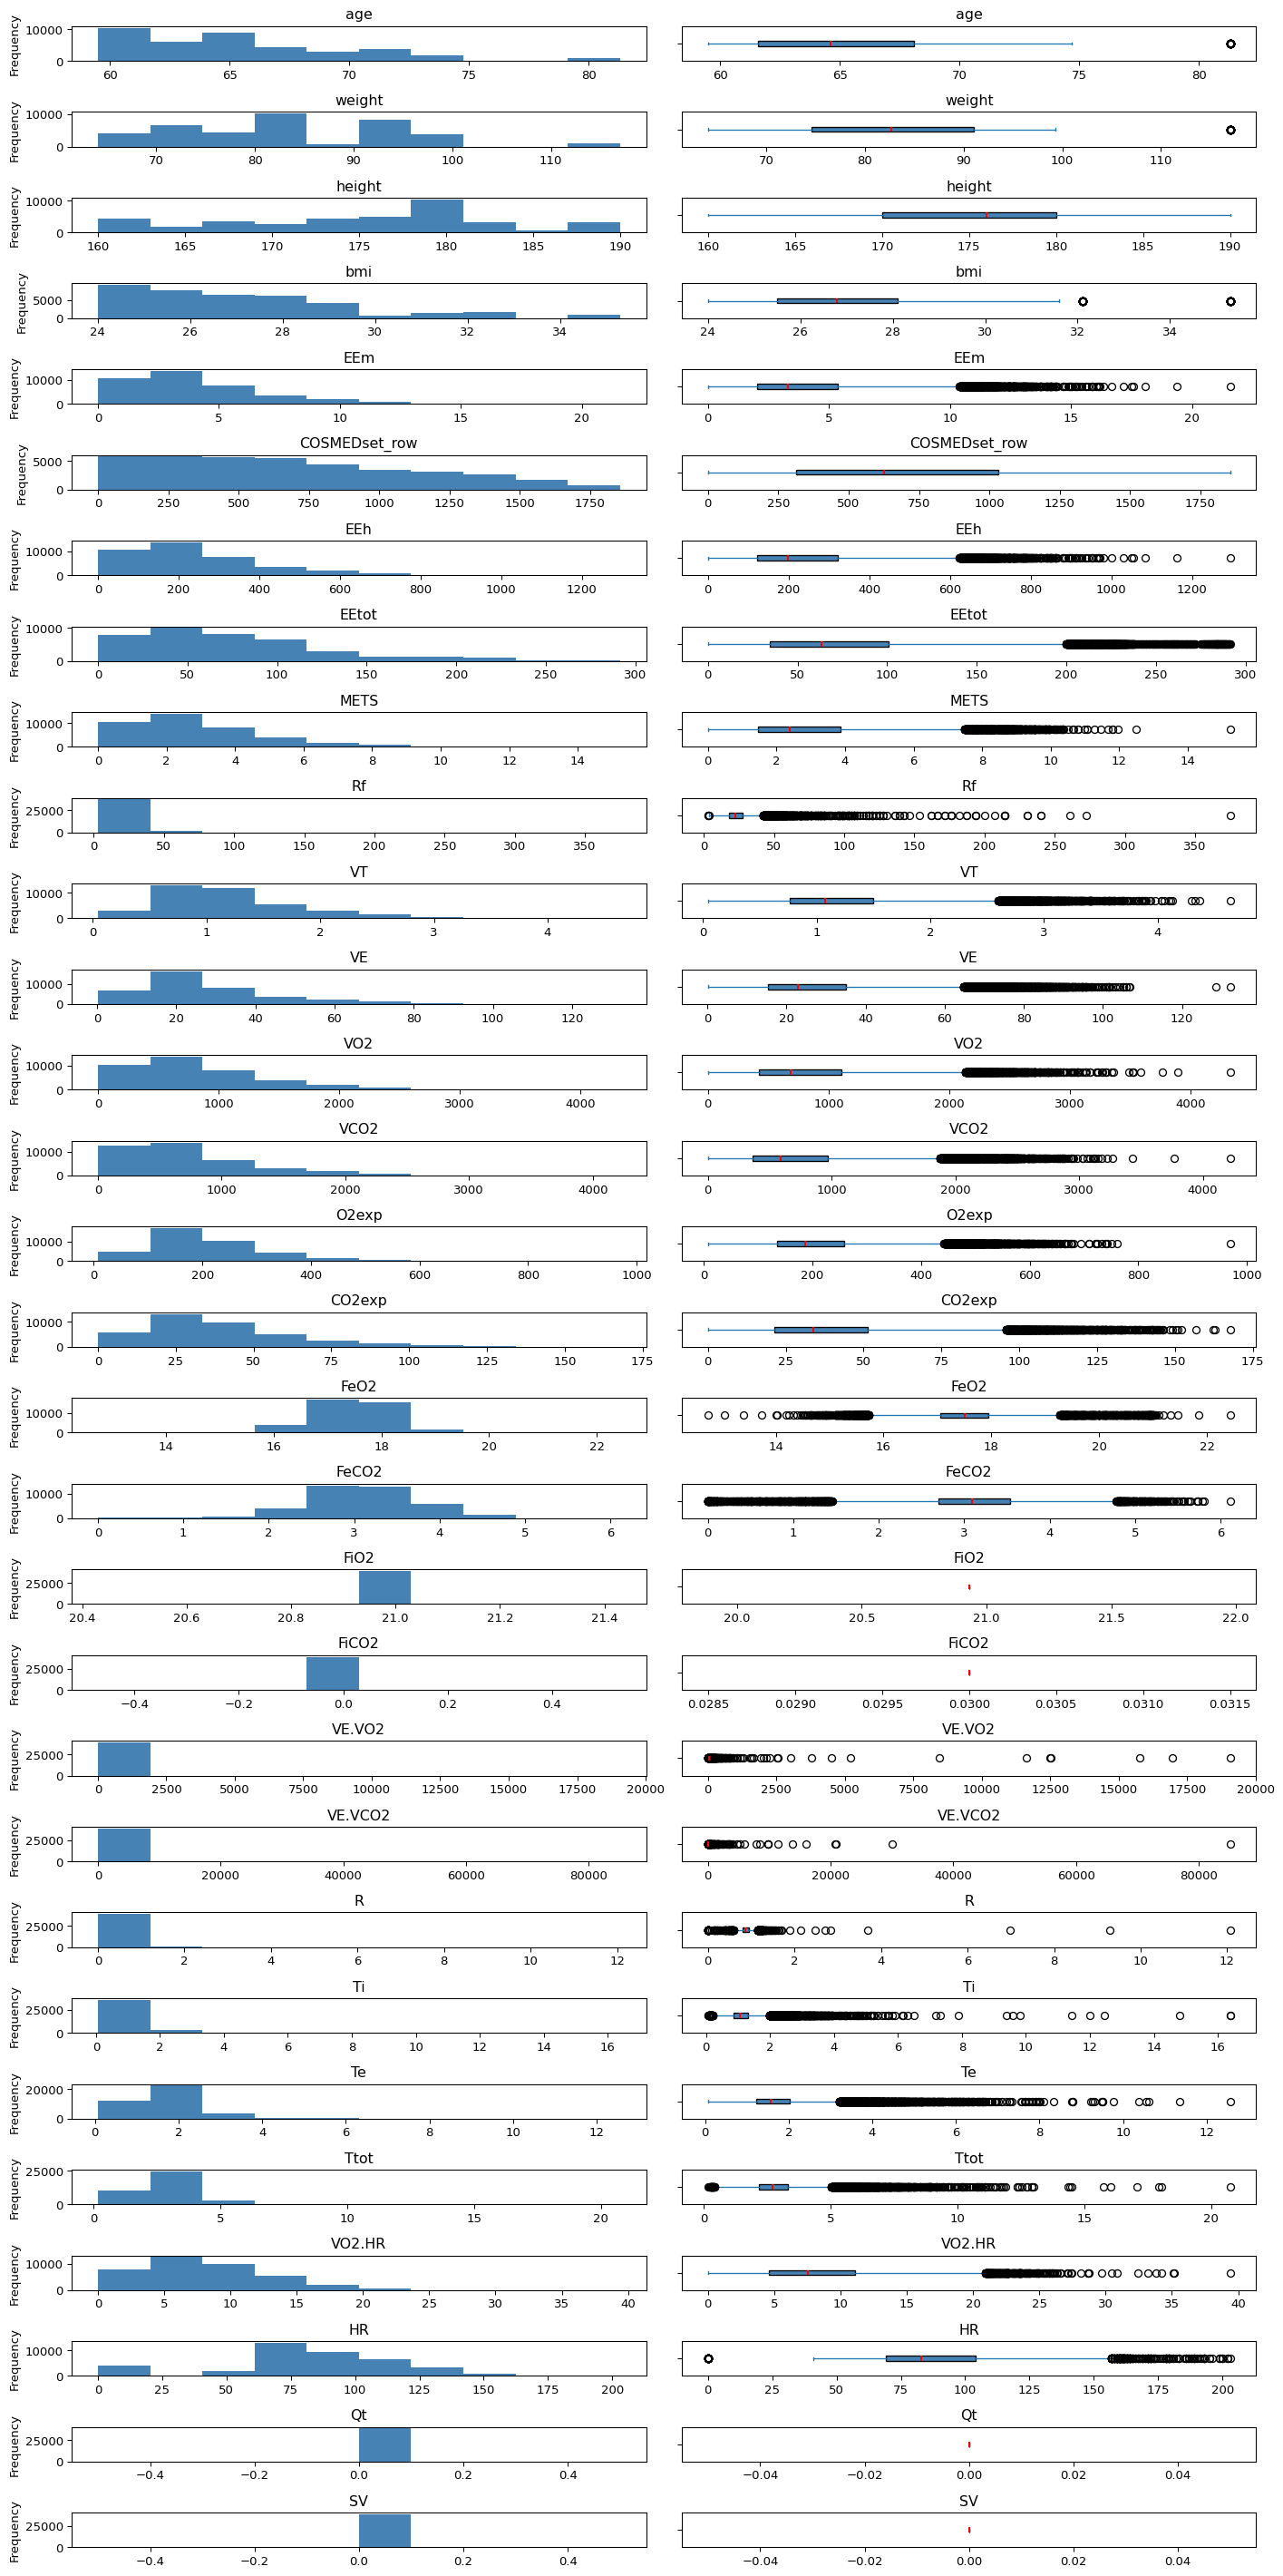

In [254]:
fig, axs = plt.subplots(len(feature_columns),2,dpi=95,figsize=(15,30))
i = 0
for col in feature_columns:
    df[col].plot(kind='hist',ax=axs[i,0], title=col, color="steelblue")
    df[col].plot(kind='box',vert=False,ax=axs[i,1], title=col,
                                             patch_artist = True,
           boxprops = dict(facecolor = "steelblue"),
                                             medianprops = dict(color = "red", linewidth = 1.5)).set_yticklabels('')

    i+=1
fig.tight_layout()
plt.show()

ajlsfh;hdfs;ajfsjdf;kljd;l